In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

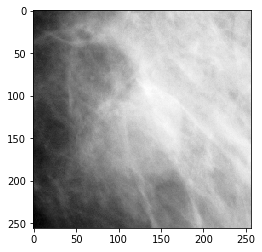

Label: [0. 1. 0. 0.]
[[[ 54.41960784  54.41960784  54.41960784]
  [ 54.56078431  54.56078431  54.56078431]
  [ 54.35294118  54.35294118  54.35294118]
  ...
  [193.71764706 193.71764706 193.71764706]
  [192.18823529 192.18823529 192.18823529]
  [187.09019608 187.09019608 187.09019608]]

 [[ 54.60392157  54.60392157  54.60392157]
  [ 55.30588235  55.30588235  55.30588235]
  [ 59.81176471  59.81176471  59.81176471]
  ...
  [190.49019608 190.49019608 190.49019608]
  [191.29411765 191.29411765 191.29411765]
  [190.03137255 190.03137255 190.03137255]]

 [[ 56.9372549   56.9372549   56.9372549 ]
  [ 59.81960784  59.81960784  59.81960784]
  [ 60.11764706  60.11764706  60.11764706]
  ...
  [193.05882353 193.05882353 193.05882353]
  [193.82352941 193.82352941 193.82352941]
  [191.75294118 191.75294118 191.75294118]]

 ...

 [[ 41.81176471  41.81176471  41.81176471]
  [ 35.0745098   35.0745098   35.0745098 ]
  [ 38.06666667  38.06666667  38.06666667]
  ...
  [181.4        181.4        181.4      

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [14]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [17]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [19]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 4.3166 - accuracy: 0.2751
Epoch 00001: val_loss improved from inf to 2.55488, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 4.2745 - accuracy: 0.2763 - val_loss: 2.5549 - val_accuracy: 0.3058
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 3.2510 - accuracy: 0.2955
Epoch 00002: val_loss improved from 2.55488 to 1.73854, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 3.1886 - accuracy: 0.2964 - val_loss: 1.7385 - val_accuracy: 0.3282
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 2.5274 - accuracy: 0.2969
Epoch 00003: val_loss improved from 1.73854 to 1.58452, saving model to vgg16_fe_drop_128_

Epoch 27/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3730 - accuracy: 0.3291
Epoch 00027: val_loss did not improve from 1.35439
19/19 [==============================] - 29s 2s/step - loss: 1.3695 - accuracy: 0.3342 - val_loss: 1.3610 - val_accuracy: 0.3505
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3754 - accuracy: 0.3436
Epoch 00028: val_loss improved from 1.35439 to 1.35138, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3764 - accuracy: 0.3445 - val_loss: 1.3514 - val_accuracy: 0.3454
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3719 - accuracy: 0.3518
Epoch 00029: val_loss did not improve from 1.35138
19/19 [==============================] - 29s 2s/step - loss: 1.3693 - accuracy: 0.3565 - val_loss: 1.3536 - val_accuracy: 0.3488
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3655 - accuracy: 0.3577
Epoch 00030: val_loss imp

18/19 [===========================>..] - ETA: 1s - loss: 1.3309 - accuracy: 0.3600
Epoch 00055: val_loss did not improve from 1.31917
19/19 [==============================] - 30s 2s/step - loss: 1.3308 - accuracy: 0.3612 - val_loss: 1.3331 - val_accuracy: 0.3780
Epoch 56/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3423 - accuracy: 0.3790
Epoch 00056: val_loss did not improve from 1.31917
19/19 [==============================] - 30s 2s/step - loss: 1.3412 - accuracy: 0.3792 - val_loss: 1.3406 - val_accuracy: 0.3608
Epoch 57/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3194 - accuracy: 0.3681
Epoch 00057: val_loss did not improve from 1.31917
19/19 [==============================] - 30s 2s/step - loss: 1.3195 - accuracy: 0.3689 - val_loss: 1.3284 - val_accuracy: 0.3900
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3323 - accuracy: 0.3790
Epoch 00058: val_loss did not improve from 1.31917
19/19 [==============================]

Epoch 84/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3054 - accuracy: 0.3863
Epoch 00084: val_loss improved from 1.30319 to 1.29444, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3048 - accuracy: 0.3865 - val_loss: 1.2944 - val_accuracy: 0.3969
Epoch 85/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2951 - accuracy: 0.4081
Epoch 00085: val_loss improved from 1.29444 to 1.28981, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2963 - accuracy: 0.4097 - val_loss: 1.2898 - val_accuracy: 0.4141
Epoch 86/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2992 - accuracy: 0.3995
Epoch 00086: val_loss did not improve from 1.28981
19/19 [==============================] - 30s 2s/step - loss: 1.2948 - accuracy: 0.4054 - val_loss: 1.2967 - val_accuracy: 0.3814
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 

Epoch 113/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2752 - accuracy: 0.4131
Epoch 00113: val_loss did not improve from 1.26817
19/19 [==============================] - 30s 2s/step - loss: 1.2776 - accuracy: 0.4101 - val_loss: 1.2755 - val_accuracy: 0.3952
Epoch 114/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2850 - accuracy: 0.3990
Epoch 00114: val_loss did not improve from 1.26817
19/19 [==============================] - 29s 2s/step - loss: 1.2873 - accuracy: 0.3943 - val_loss: 1.2843 - val_accuracy: 0.3935
Epoch 115/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2832 - accuracy: 0.4212
Epoch 00115: val_loss did not improve from 1.26817
19/19 [==============================] - 30s 2s/step - loss: 1.2846 - accuracy: 0.4183 - val_loss: 1.2874 - val_accuracy: 0.3952
Epoch 116/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2874 - accuracy: 0.4026
Epoch 00116: val_loss did not improve from 1.26817
19/19 [==============

Epoch 142/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2623 - accuracy: 0.4158
Epoch 00142: val_loss did not improve from 1.25531
19/19 [==============================] - 30s 2s/step - loss: 1.2621 - accuracy: 0.4166 - val_loss: 1.2663 - val_accuracy: 0.4038
Epoch 143/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2626 - accuracy: 0.4235
Epoch 00143: val_loss did not improve from 1.25531
19/19 [==============================] - 29s 2s/step - loss: 1.2619 - accuracy: 0.4239 - val_loss: 1.2739 - val_accuracy: 0.4089
Epoch 144/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2449 - accuracy: 0.4203
Epoch 00144: val_loss did not improve from 1.25531
19/19 [==============================] - 29s 2s/step - loss: 1.2449 - accuracy: 0.4221 - val_loss: 1.2740 - val_accuracy: 0.4124
Epoch 145/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2673 - accuracy: 0.4176
Epoch 00145: val_loss did not improve from 1.25531
19/19 [==============

Epoch 171/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2472 - accuracy: 0.4262
Epoch 00171: val_loss did not improve from 1.23589
19/19 [==============================] - 30s 2s/step - loss: 1.2479 - accuracy: 0.4294 - val_loss: 1.2550 - val_accuracy: 0.4244
Epoch 172/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2525 - accuracy: 0.4240
Epoch 00172: val_loss did not improve from 1.23589
19/19 [==============================] - 29s 2s/step - loss: 1.2516 - accuracy: 0.4251 - val_loss: 1.2482 - val_accuracy: 0.4296
Epoch 173/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2405 - accuracy: 0.4290
Epoch 00173: val_loss did not improve from 1.23589
19/19 [==============================] - 30s 2s/step - loss: 1.2415 - accuracy: 0.4290 - val_loss: 1.2394 - val_accuracy: 0.4605
Epoch 174/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2642 - accuracy: 0.4340
Epoch 00174: val_loss did not improve from 1.23589
19/19 [==============

18/19 [===========================>..] - ETA: 1s - loss: 1.2355 - accuracy: 0.4294
Epoch 00200: val_loss did not improve from 1.22217
19/19 [==============================] - 30s 2s/step - loss: 1.2331 - accuracy: 0.4311 - val_loss: 1.2372 - val_accuracy: 0.4450


In [20]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [22]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [23]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 200
Epoch [opt]: 179
Valid accuracy [end]: 0.4450
Valid accuracy [opt]: 0.4656
Test accuracy [end]:  0.4458
Test accuracy [opt]:  0.4336
Valid loss [end]: 1.2372
Valid loss [opt]: 1.2222
Test loss [end]:  1.2152
Test loss [opt]:  1.2293


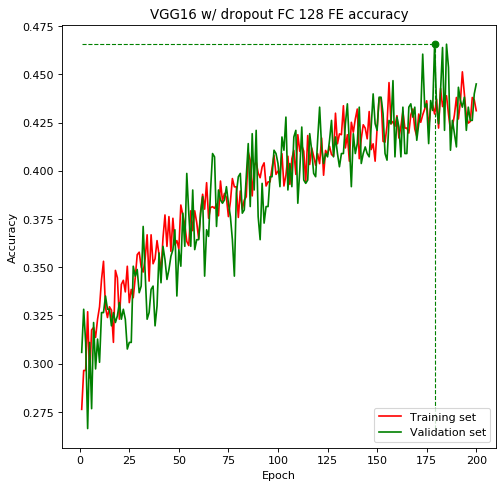

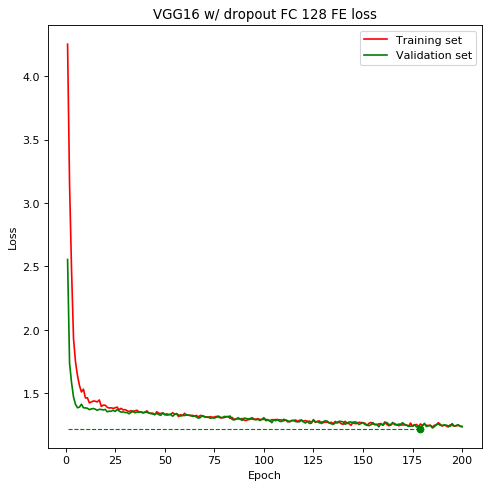

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 4.9828 - accuracy: 0.2860
Epoch 00001: val_loss improved from inf to 2.80308, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 4.9176 - accuracy: 0.2900 - val_loss: 2.8031 - val_accuracy: 0.2801
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 3.4622 - accuracy: 0.2914
Epoch 00002: val_loss improved from 2.80308 to 2.19431, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 3.4596 - accuracy: 0.2887 - val_loss: 2.1943 - val_accuracy: 0.3024
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 2.9106 - accuracy: 0.2951
Epoch 00003: val_loss improved from 2.19431 to 2.06724, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 2.8

18/19 [===========================>..] - ETA: 1s - loss: 1.4118 - accuracy: 0.3404
Epoch 00027: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.4143 - accuracy: 0.3398 - val_loss: 1.3646 - val_accuracy: 0.3351
Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3940 - accuracy: 0.3550
Epoch 00028: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.3949 - accuracy: 0.3556 - val_loss: 1.3509 - val_accuracy: 0.3402
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3855 - accuracy: 0.3323
Epoch 00029: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.3899 - accuracy: 0.3346 - val_loss: 1.3548 - val_accuracy: 0.3540
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3841 - accuracy: 0.3482
Epoch 00030: val_loss improved from 1.35066 to 1.34679, saving model to vgg16_fe_drop_256

Epoch 56/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3181 - accuracy: 0.3795
Epoch 00056: val_loss improved from 1.33000 to 1.32055, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3220 - accuracy: 0.3788 - val_loss: 1.3206 - val_accuracy: 0.3780
Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3339 - accuracy: 0.3827
Epoch 00057: val_loss did not improve from 1.32055
19/19 [==============================] - 29s 2s/step - loss: 1.3360 - accuracy: 0.3801 - val_loss: 1.3323 - val_accuracy: 0.3540
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3192 - accuracy: 0.3804
Epoch 00058: val_loss did not improve from 1.32055
19/19 [==============================] - 29s 2s/step - loss: 1.3216 - accuracy: 0.3767 - val_loss: 1.3208 - val_accuracy: 0.3694
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3174 - accuracy: 0.3863
Epoch 00059: val_loss did

Epoch 85/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3163 - accuracy: 0.3768
Epoch 00085: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.3136 - accuracy: 0.3831 - val_loss: 1.3136 - val_accuracy: 0.3763
Epoch 86/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3040 - accuracy: 0.3858
Epoch 00086: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.3028 - accuracy: 0.3895 - val_loss: 1.3058 - val_accuracy: 0.3763
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2991 - accuracy: 0.3872
Epoch 00087: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.2986 - accuracy: 0.3891 - val_loss: 1.3063 - val_accuracy: 0.3918
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3054 - accuracy: 0.3931
Epoch 00088: val_loss did not improve from 1.30022
19/19 [==================

Epoch 114/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2791 - accuracy: 0.4117
Epoch 00114: val_loss did not improve from 1.26618
19/19 [==============================] - 30s 2s/step - loss: 1.2808 - accuracy: 0.4110 - val_loss: 1.2785 - val_accuracy: 0.4330
Epoch 115/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2808 - accuracy: 0.4044
Epoch 00115: val_loss did not improve from 1.26618
19/19 [==============================] - 29s 2s/step - loss: 1.2828 - accuracy: 0.4024 - val_loss: 1.2727 - val_accuracy: 0.4210
Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2825 - accuracy: 0.4140
Epoch 00116: val_loss did not improve from 1.26618
19/19 [==============================] - 29s 2s/step - loss: 1.2852 - accuracy: 0.4114 - val_loss: 1.2813 - val_accuracy: 0.4089
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2868 - accuracy: 0.4099
Epoch 00117: val_loss did not improve from 1.26618
19/19 [==============

18/19 [===========================>..] - ETA: 1s - loss: 1.2434 - accuracy: 0.4258
Epoch 00143: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2459 - accuracy: 0.4217 - val_loss: 1.2666 - val_accuracy: 0.4227
Epoch 144/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2530 - accuracy: 0.4303
Epoch 00144: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2564 - accuracy: 0.4290 - val_loss: 1.2727 - val_accuracy: 0.3900
Epoch 145/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2637 - accuracy: 0.4181
Epoch 00145: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2642 - accuracy: 0.4221 - val_loss: 1.2625 - val_accuracy: 0.4107
Epoch 146/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2807 - accuracy: 0.4140
Epoch 00146: val_loss did not improve from 1.24959
19/19 [============================

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 150
Epoch [opt]: 148
Valid accuracy [end]: 0.3935
Valid accuracy [opt]: 0.4261
Test accuracy [end]:  0.4046
Test accuracy [opt]:  0.4000
Valid loss [end]: 1.2693
Valid loss [opt]: 1.2456
Test loss [end]:  1.2496
Test loss [opt]:  1.2507


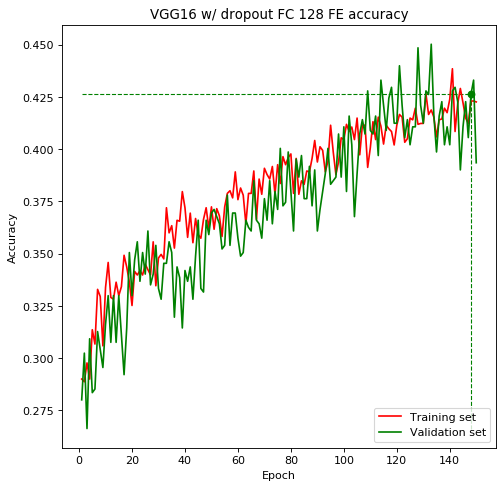

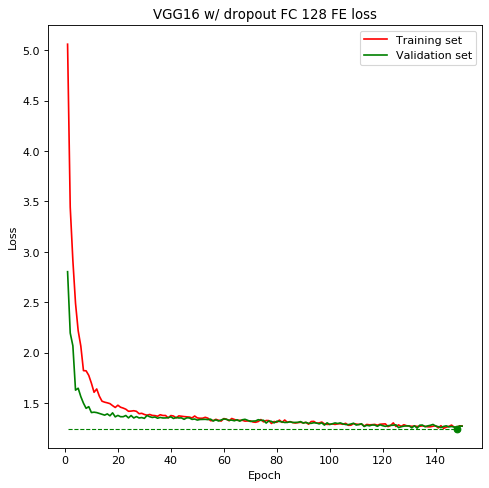

In [34]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [35]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [40]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [41]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2482 - accuracy: 0.4360
Epoch 00001: val_loss improved from inf to 1.25783, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.2534 - accuracy: 0.4346 - val_loss: 1.2578 - val_accuracy: 0.4227
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2538 - accuracy: 0.4367
Epoch 00002: val_loss did not improve from 1.25783
11/11 [==============================] - 21s 2s/step - loss: 1.2580 - accuracy: 0.4347 - val_loss: 1.2593 - val_accuracy: 0.4381
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2736 - accuracy: 0.4224
Epoch 00003: val_loss did not improve from 1.25783
11/11 [==============================] - 20s 2s/step - loss: 1.2661 - accuracy: 0.4308 - val_loss: 1.2628 - val_accuracy: 0.4313
Epoch 4/200
10/11 [====================

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2302 - accuracy: 0.4430
Epoch 00029: val_loss did not improve from 1.22618
11/11 [==============================] - 21s 2s/step - loss: 1.2318 - accuracy: 0.4418 - val_loss: 1.2562 - val_accuracy: 0.4313
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2056 - accuracy: 0.4792
Epoch 00030: val_loss did not improve from 1.22618
11/11 [==============================] - 20s 2s/step - loss: 1.2080 - accuracy: 0.4744 - val_loss: 1.2271 - val_accuracy: 0.4244
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2437 - accuracy: 0.4258
Epoch 00031: val_loss did not improve from 1.22618
11/11 [==============================] - 22s 2s/step - loss: 1.2418 - accuracy: 0.4247 - val_loss: 1.2404 - val_accuracy: 0.4330
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2338 - accuracy: 0.4309
Epoch 00032: val_loss did not improve from 1.22618
11/11 [==================

Epoch 58/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2048 - accuracy: 0.4631
Epoch 00058: val_loss did not improve from 1.19238
11/11 [==============================] - 20s 2s/step - loss: 1.2105 - accuracy: 0.4598 - val_loss: 1.2173 - val_accuracy: 0.4467
Epoch 59/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2238 - accuracy: 0.4352
Epoch 00059: val_loss did not improve from 1.19238
11/11 [==============================] - 22s 2s/step - loss: 1.2168 - accuracy: 0.4425 - val_loss: 1.2163 - val_accuracy: 0.4725
Epoch 60/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2002 - accuracy: 0.4436
Epoch 00060: val_loss did not improve from 1.19238
11/11 [==============================] - 20s 2s/step - loss: 1.1973 - accuracy: 0.4491 - val_loss: 1.2157 - val_accuracy: 0.4622
Epoch 61/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2033 - accuracy: 0.4343
Epoch 00061: val_loss did not improve from 1.19238
11/11 [==================

10/11 [==========================>...] - ETA: 1s - loss: 1.2079 - accuracy: 0.4742
Epoch 00087: val_loss did not improve from 1.17023
11/11 [==============================] - 22s 2s/step - loss: 1.2018 - accuracy: 0.4744 - val_loss: 1.1917 - val_accuracy: 0.4570
Epoch 88/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1835 - accuracy: 0.4641
Epoch 00088: val_loss did not improve from 1.17023
11/11 [==============================] - 21s 2s/step - loss: 1.1878 - accuracy: 0.4595 - val_loss: 1.1895 - val_accuracy: 0.4639
Epoch 89/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1856 - accuracy: 0.4617
Epoch 00089: val_loss did not improve from 1.17023
11/11 [==============================] - 21s 2s/step - loss: 1.1919 - accuracy: 0.4602 - val_loss: 1.1841 - val_accuracy: 0.4742
Epoch 90/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1916 - accuracy: 0.4492
Epoch 00090: val_loss did not improve from 1.17023
11/11 [==============================]

10/11 [==========================>...] - ETA: 1s - loss: 1.1679 - accuracy: 0.4640
Epoch 00116: val_loss did not improve from 1.15526
11/11 [==============================] - 20s 2s/step - loss: 1.1581 - accuracy: 0.4736 - val_loss: 1.2031 - val_accuracy: 0.4485
Epoch 117/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1753 - accuracy: 0.4631
Epoch 00117: val_loss did not improve from 1.15526
11/11 [==============================] - 21s 2s/step - loss: 1.1726 - accuracy: 0.4660 - val_loss: 1.1863 - val_accuracy: 0.4914
Epoch 118/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1668 - accuracy: 0.4843
Epoch 00118: val_loss did not improve from 1.15526
11/11 [==============================] - 21s 2s/step - loss: 1.1680 - accuracy: 0.4866 - val_loss: 1.1822 - val_accuracy: 0.4845
Epoch 119/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1892 - accuracy: 0.4828
Epoch 00119: val_loss did not improve from 1.15526
11/11 [============================

10/11 [==========================>...] - ETA: 1s - loss: 1.1432 - accuracy: 0.4860
Epoch 00145: val_loss did not improve from 1.14638
11/11 [==============================] - 20s 2s/step - loss: 1.1445 - accuracy: 0.4897 - val_loss: 1.1607 - val_accuracy: 0.4828
Epoch 146/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1580 - accuracy: 0.4784
Epoch 00146: val_loss did not improve from 1.14638
11/11 [==============================] - 21s 2s/step - loss: 1.1598 - accuracy: 0.4805 - val_loss: 1.1774 - val_accuracy: 0.4622
Epoch 147/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1686 - accuracy: 0.4589
Epoch 00147: val_loss did not improve from 1.14638
11/11 [==============================] - 21s 2s/step - loss: 1.1669 - accuracy: 0.4598 - val_loss: 1.1544 - val_accuracy: 0.4828
Epoch 148/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1556 - accuracy: 0.4766
Epoch 00148: val_loss did not improve from 1.14638
11/11 [============================

In [42]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [43]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 164
Epoch [opt]: 134
Valid accuracy [end]: 0.4811
Valid accuracy [opt]: 0.5017
Test accuracy [end]:  0.4901
Test accuracy [opt]:  0.4794
Valid loss [end]: 1.1749
Valid loss [opt]: 1.1464
Test loss [end]:  1.1250
Test loss [opt]:  1.1419


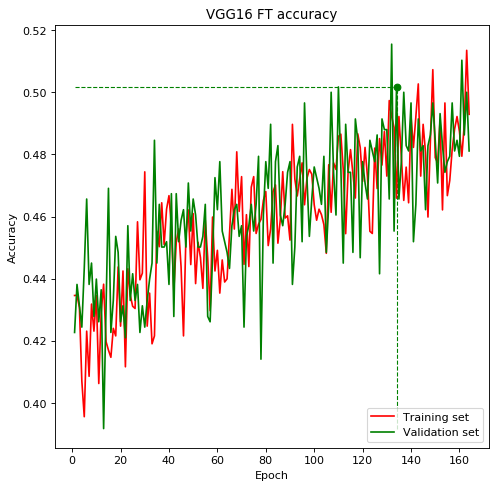

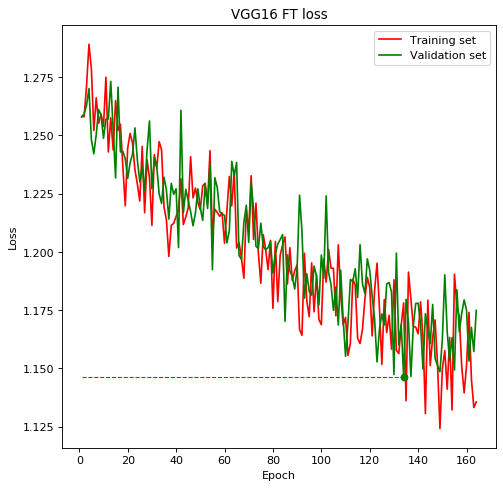

In [44]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [45]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [46]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1645 - accuracy: 0.4766
Epoch 00001: val_loss improved from inf to 1.15165, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.1547 - accuracy: 0.4790 - val_loss: 1.1517 - val_accuracy: 0.4828
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1619 - accuracy: 0.4836
Epoch 00002: val_loss did not improve from 1.15165
11/11 [==============================] - 22s 2s/step - loss: 1.1630 - accuracy: 0.4787 - val_loss: 1.1536 - val_accuracy: 0.4845
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1649 - accuracy: 0.4826
Epoch 00003: val_loss did not improve from 1.15165
11/11 [==============================] - 20s 2s/step - loss: 1.1691 - accuracy: 0.4797 - val_loss: 1.1993 - val_accuracy: 0.4519
Epoch 4/200
10/11 [====================

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1117 - accuracy: 0.5047
Epoch 00029: val_loss did not improve from 1.12181
11/11 [==============================] - 20s 2s/step - loss: 1.1122 - accuracy: 0.5111 - val_loss: 1.1458 - val_accuracy: 0.4897
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1351 - accuracy: 0.5081
Epoch 00030: val_loss did not improve from 1.12181
11/11 [==============================] - 21s 2s/step - loss: 1.1343 - accuracy: 0.5042 - val_loss: 1.1344 - val_accuracy: 0.4845
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1342 - accuracy: 0.5125
Epoch 00031: val_loss did not improve from 1.12181
11/11 [==============================] - 22s 2s/step - loss: 1.1365 - accuracy: 0.5099 - val_loss: 1.1408 - val_accuracy: 0.5017
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1316 - accuracy: 0.4727
Epoch 00032: val_loss did not improve from 1.12181
11/11 [==================

In [ ]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();